In [1]:
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['WA_Fn-UseC_-Telco-Customer-Churn.csv']))

print(df.head())


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...

In [2]:
# Check for any blank or missing in 'TotalCharges'
print(df['TotalCharges'].unique()[:10])  # Look for weird values

# Convert 'TotalCharges' to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values now
print(df['TotalCharges'].isnull().sum())

# Drop or fill missing values (usually very few)
df = df.dropna(subset=['TotalCharges'])


['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']
11


In [3]:
# List categorical columns except target
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('customerID')  # Remove ID column
cat_cols.remove('Churn')       # Target column

# Encode 'Churn' as binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Use get_dummies for categorical features
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df_encoded.head())


   customerID  SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  \
0  7590-VHVEG              0       1           29.85         29.85      0   
1  5575-GNVDE              0      34           56.95       1889.50      0   
2  3668-QPYBK              0       2           53.85        108.15      1   
3  7795-CFOCW              0      45           42.30       1840.75      0   
4  9237-HQITU              0       2           70.70        151.65      1   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0        False         True           False             False  ...   
1         True        False           False              True  ...   
2         True        False           False              True  ...   
3         True        False           False             False  ...   
4        False        False           False              True  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1     

Churn
0    5163
1    1869
Name: count, dtype: int64


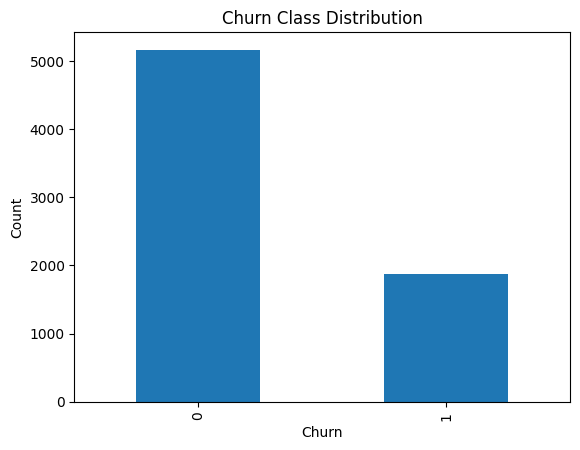

In [4]:
import matplotlib.pyplot as plt

# Count of churn classes
churn_counts = df_encoded['Churn'].value_counts()
print(churn_counts)

# Plot churn distribution
churn_counts.plot(kind='bar')
plt.title('Churn Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split dataset first (to avoid data leakage)
X = df_encoded.drop(['customerID', 'Churn'], axis=1, errors='ignore')  # Drop customerID if still there
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Before SMOTE, counts of label '1': {}".format(sum(y_train==1)))
print("Before SMOTE, counts of label '0': {} \n".format(sum(y_train==0)))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_sm==0)))


Before SMOTE, counts of label '1': 1495
Before SMOTE, counts of label '0': 4130 

After SMOTE, counts of label '1': 4130
After SMOTE, counts of label '0': 4130


Training Logistic Regression...
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1033
           1       0.55      0.65      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407

AUC-ROC: 0.8168
Confusion Matrix:
[[836 197]
 [132 242]]


Training Random Forest...
--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.58      0.59      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

AUC-ROC: 0.8153
Confusion Matrix:
[[874 159]
 [153 221]]


Training XGBoost...
--- XGBoost ---
              precision    recall  f1-score   support

           0       0.84      

<Figure size 800x600 with 0 Axes>

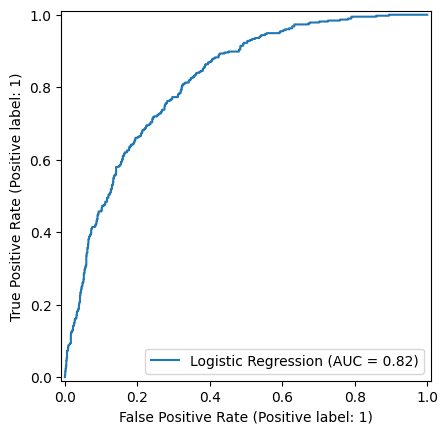

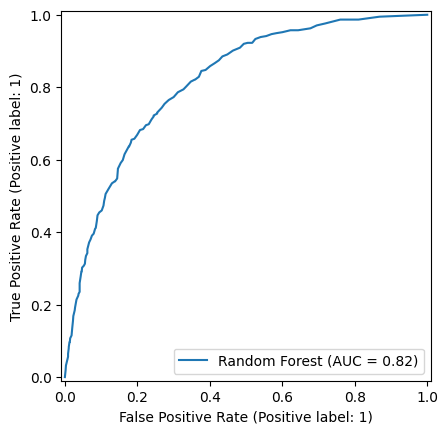

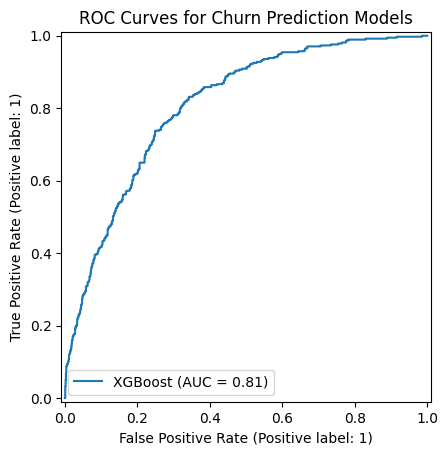

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=3000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"Training {name}...")

    # For Logistic Regression use scaled data, otherwise original
    if name == 'Logistic Regression':
        model.fit(X_train_sm_scaled, y_train_sm)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train_sm, y_train_sm)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)

plt.title('ROC Curves for Churn Prediction Models')
plt.legend()
plt.show()


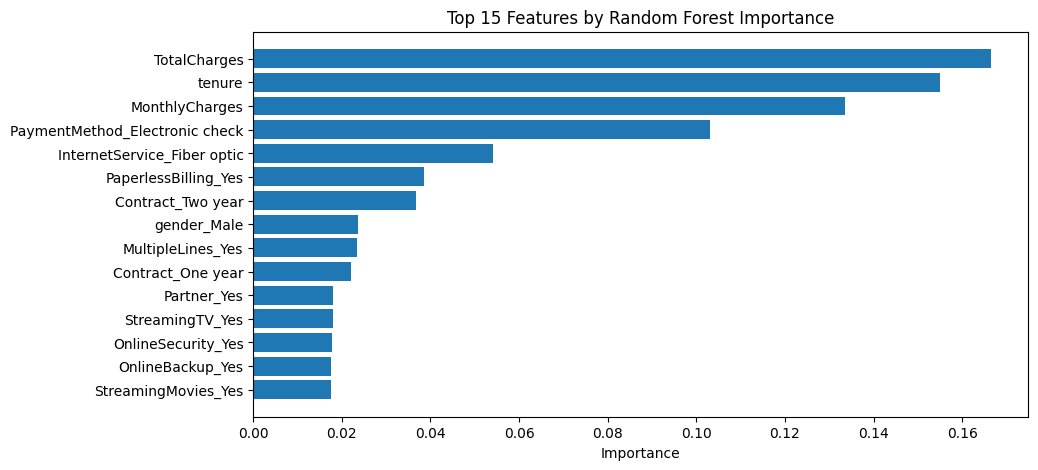

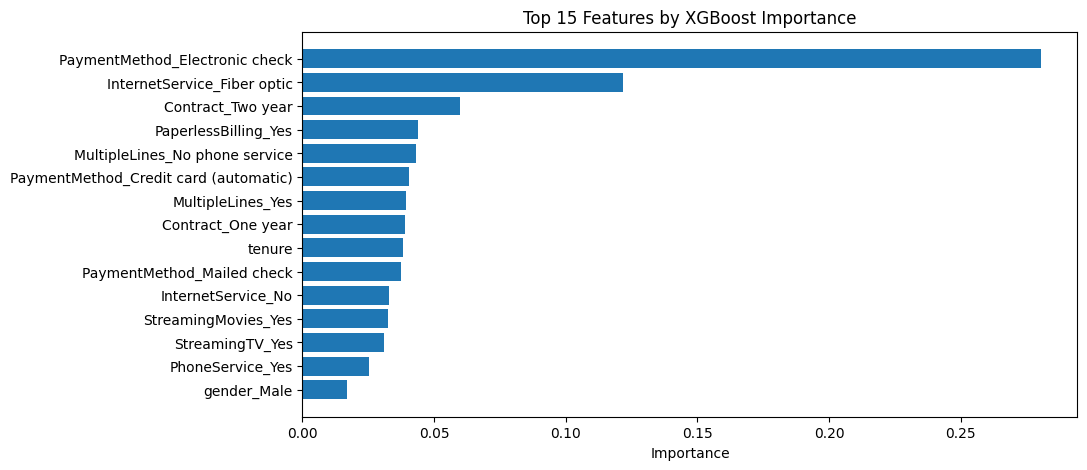

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names (columns)
feature_names = X_train.columns

# Random Forest feature importance
rf_model = models['Random Forest']
rf_importances = rf_model.feature_importances_

# XGBoost feature importance
xgb_model = models['XGBoost']
xgb_importances = xgb_model.feature_importances_

# Create DataFrame for easier plotting
rf_feat_df = pd.DataFrame({'feature': feature_names, 'importance': rf_importances}).sort_values(by='importance', ascending=False).head(15)
xgb_feat_df = pd.DataFrame({'feature': feature_names, 'importance': xgb_importances}).sort_values(by='importance', ascending=False).head(15)

# Plot Random Forest top features
plt.figure(figsize=(10,5))
plt.barh(rf_feat_df['feature'][::-1], rf_feat_df['importance'][::-1])
plt.title('Top 15 Features by Random Forest Importance')
plt.xlabel('Importance')
plt.show()

# Plot XGBoost top features
plt.figure(figsize=(10,5))
plt.barh(xgb_feat_df['feature'][::-1], xgb_feat_df['importance'][::-1])
plt.title('Top 15 Features by XGBoost Importance')
plt.xlabel('Importance')
plt.show()


In [9]:
import pickle

# Example: Save Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(models['Random Forest'], f)

# Similarly, save Logistic Regression model and scaler if you want
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(models['Logistic Regression'], f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [10]:
from google.colab import files

files.download('random_forest_model.pkl')
files.download('logistic_regression_model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>